In [1]:
#!pip install universal_pathlib

In [2]:
import numpy as np
import pandas as pd
from upath import UPath as Path

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import scale

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
files_dir = Path("/Users/ewheeler/dev/UNDatathon/data/gdelt_files/")

In [5]:
def make_country_name_mapper(location_column_name, extra_from=None):
    # TODO caller needs a way to find out what `location_column_names` are possible
    # and/or we should match shorthands like
    # {'unicef': 'UNICEFOU', 'iso3': 'ISO3 (geonames)'}
    territory_identifiers = pd.read_csv(files_dir / "country-codes/country_codes.csv")

    class CountryNameMapper:
        # TODO add docstring
        def __init__(self, location_column_name, codes, extra_from):
            self.map = dict()
            self.codes = codes
        
            # these columns have country name strings in various formats
            ccode_name_cols = ['Country or Area_en (M49)', 'English Short (unterm)',
                               'English Formal (unterm)', 'name_short (exio-wiod-eora)',
                               'name_official (exio-wiod-eora)', 'Short name (fao)',
                               'Official name (fao)', 'Country (geonames)']
            if extra_from is not None:
                for extra in extra_from:
                    ccode_name_cols.append(extra)

            # make mapping of all various country name formats to desired location_column_name contents
            for country_name_col in ccode_name_cols:
                self.map.update(dict(self.codes[[country_name_col, location_column_name]].dropna().values))
            print(len(self.map.keys()))
        
        def __call__(self, location_name):
            # TODO might want to return the original location_name if not matched.
            # should make_location_name_mapper take some kind of 'missing value handler' parameter?
            return self.map.get(location_name, pd.NA)
        
    return CountryNameMapper(location_column_name, territory_identifiers, extra_from)

In [6]:
iso3_mapper = make_country_name_mapper('ISO3 (geonames)', extra_from=['fips (geonames)', 'M49 Code (M49)'])

1141


In [7]:
gdelt_query = 'food'

In [8]:
datasets = list(files_dir.glob(f'*{gdelt_query}*.feather'))
datasets

[PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinetone.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinevol.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_artlist.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinevolraw.feather')]

In [9]:
_df_tone = pd.read_feather(datasets[0])
_df_tone

,Date,Series,Value,fips,query,api_mode
0,2020-01-01,Average Tone,0.9926,CV,food,timelinetone
1,2020-01-02,Average Tone,-3.3071,CV,food,timelinetone
2,2020-01-03,Average Tone,0.0000,CV,food,timelinetone
3,2020-01-04,Average Tone,0.0000,CV,food,timelinetone
4,2020-01-05,Average Tone,0.0000,CV,food,timelinetone
...,...,...,...,...,...,...
1393,2023-10-27,Average Tone,-4.3418,SI,food,timelinetone
1394,2023-10-28,Average Tone,-2.1853,SI,food,timelinetone
1395,2023-10-29,Average Tone,-0.4722,SI,food,timelinetone
1396,2023-10-30,Average Tone,-1.8085,SI,food,timelinetone


In [10]:
_df_vol = pd.read_feather(datasets[1])
_df_vol

,Date,Series,Value,fips,query,api_mode
0,2020-01-01,Volume Intensity,0.0000,AY,food,volumeintensity
1,2020-01-02,Volume Intensity,0.0000,AY,food,volumeintensity
2,2020-01-03,Volume Intensity,0.0000,AY,food,volumeintensity
3,2020-01-04,Volume Intensity,0.0000,AY,food,volumeintensity
4,2020-01-05,Volume Intensity,0.0000,AY,food,volumeintensity
...,...,...,...,...,...,...
1393,2023-10-27,Volume Intensity,0.0023,SU,food,volumeintensity
1394,2023-10-28,Volume Intensity,0.0014,SU,food,volumeintensity
1395,2023-10-29,Volume Intensity,0.0054,SU,food,volumeintensity
1396,2023-10-30,Volume Intensity,0.0038,SU,food,volumeintensity


In [11]:
_df_art = pd.read_feather(datasets[2])
_df_art

,URL,MobileURL,Date,Title,fips,query,api_mode
0,https://lapagina.com.sv/nacionales/impulsan-la...,None,2023-08-09 23:45:00,Impulsan la inocuidad alimentaria con el progr...,ES,food,artlist
1,https://lapagina.com.sv/nacionales/anuncian-la...,None,2023-09-07 20:30:00,Anuncian la construcción de la primera central...,ES,food,artlist
2,https://lapagina.com.sv/nacionales/asamblea-ap...,None,2023-08-24 19:15:00,Asamblea aprueba que Policías continúen recibi...,ES,food,artlist
3,https://lapagina.com.sv/nacionales/fosalud-org...,None,2023-08-17 15:45:00,Fosalud organiza actividades para difundir la ...,ES,food,artlist
4,https://lapagina.com.sv/nacionales/pescadores-...,None,2023-09-15 17:15:00,Pescadores de Usulután reciben insumos y paque...,ES,food,artlist
...,...,...,...,...,...,...,...
5,http://www.alwatwan.net/economie/premi%C3%A8re...,None,2023-09-13 07:00:00,Premières journées scientifiques de lInrape I ...,CN,food,artlist
6,http://www.alwatwan.net/societe/coupures-d%E2%...,None,2023-10-13 04:45:00,Coupures d électricité à Ngazidja I Des entre...,CN,food,artlist
7,http://www.alwatwan.net/politique/78%C3%A8me-a...,None,2023-09-22 06:15:00,78ème Assemblée Générale des Nations Unies I L...,CN,food,artlist
0,https://www.gov.ms/2023/09/20/post-cabinet-pre...,None,2023-09-20 23:00:00,POST CABINET PRESS NOTES FOR 14TH SEPTEMBER 2023,MH,food,artlist


In [12]:
_df_volraw = pd.read_feather(datasets[3])
_df_volraw

,Date,Series,Value,fips,query,api_mode
0,2020-01-01,Article Count,1.0,CK,food,timelinevolraw
1,2020-01-01,Total Monitored Articles,262970.0,CK,food,timelinevolraw
2,2020-01-02,Article Count,5.0,CK,food,timelinevolraw
3,2020-01-02,Total Monitored Articles,389269.0,CK,food,timelinevolraw
4,2020-01-03,Article Count,1.0,CK,food,timelinevolraw
...,...,...,...,...,...,...
2791,2023-10-29,Total Monitored Articles,110515.0,NP,food,timelinevolraw
2792,2023-10-30,Article Count,12.0,NP,food,timelinevolraw
2793,2023-10-30,Total Monitored Articles,129977.0,NP,food,timelinevolraw
2794,2023-10-31,Article Count,35.0,NP,food,timelinevolraw


In [13]:
def mutate_vol_df(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.index = df['Date']
    df['iso3'] = df['fips'].map(iso3_mapper)
    df['Value_scaled'] = df.groupby('iso3')['Value'].transform(lambda x: scale(x))
    
    df_vol = df.groupby(['query', 'iso3', pd.Grouper(freq='M')]).sum(numeric_only=True).reset_index()
    df_vol['Date'] = df_vol['Date'].dt.normalize().map(lambda x : x.replace(day=1))
    df_vol = df_vol.rename(columns={'Value': 'timelinevol_orig', 'Value_scaled': 'timelinevol'})
    df_vol = df_vol.drop(columns=['query'])
    return df_vol

In [14]:
def mutate_tone_df(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.index = df['Date']
    df['iso3'] = df['fips'].map(iso3_mapper)
    df['Value_scaled'] = df.groupby('iso3')['Value'].transform(lambda x: scale(x))

    df_tone = df.groupby(['query', 'iso3', pd.Grouper(freq='M')]).sum(numeric_only=True).reset_index()
    df_tone['Date'] = df_tone['Date'].dt.normalize().map(lambda x : x.replace(day=1))
    df_tone = df_tone.rename(columns={'Value': 'timelinetone_orig', 'Value_scaled': 'timelinetone'})
    df_tone = df_tone.drop(columns=['query'])
    return df_tone

In [15]:
def mutate_cpi_df(df):
    df = df[df['Item'] == 'Food price inflation']
    df_fp = df[['Year', 'Months', 'Area Code (M49)', 'Area', 'Value']]
    df_fp['Date'] = pd.to_datetime(df_fp['Year'].astype(str) + ' ' + df_fp['Months']).dt.normalize()
    df_fp['cpi_orig'] = df_fp['Value'].astype(float)
    df_fp['iso3'] = df_fp['Area Code (M49)'].map(iso3_mapper)
    df_fp['cpi'] = df_fp.groupby('iso3')['cpi_orig'].transform(lambda x: scale(x))

    return df_fp[['Date', 'iso3', 'cpi', 'cpi_orig']]

In [16]:
_df_fp = pd.read_csv(files_dir / 'FAOSTAT_data_en_.csv')
df_fp = mutate_cpi_df(_df_fp)

In [17]:
df_vol = mutate_vol_df(_df_vol)
df_tone = mutate_tone_df(_df_tone)

In [18]:
df_vol

,iso3,Date,timelinevol_orig,timelinevol
0,ABW,2020-01-01,0.0000,-1.161558
1,ABW,2020-02-01,0.0000,-1.086619
2,ABW,2020-03-01,0.0000,-1.161558
3,ABW,2020-04-01,0.0000,-1.124088
4,ABW,2020-05-01,0.0000,-1.161558
...,...,...,...,...
10069,ZWE,2023-06-01,0.2061,11.142314
10070,ZWE,2023-07-01,0.2399,21.378492
10071,ZWE,2023-08-01,0.2346,19.437041
10072,ZWE,2023-09-01,0.2097,12.461035


In [19]:
df_tone

,iso3,Date,timelinetone_orig,timelinetone
0,ABW,2020-01-01,0.0000,1.051377
1,ABW,2020-02-01,0.0000,0.983546
2,ABW,2020-03-01,0.0000,1.051377
3,ABW,2020-04-01,0.0000,1.017462
4,ABW,2020-05-01,0.0000,1.051377
...,...,...,...,...
10069,ZWE,2023-06-01,-22.4871,9.131794
10070,ZWE,2023-07-01,-2.5441,24.654237
10071,ZWE,2023-08-01,-18.8438,12.666859
10072,ZWE,2023-09-01,-2.7245,23.665911


In [20]:
df_gdelt = (df_tone.set_index(['iso3', 'Date'])
                   .join(df_vol.set_index(['iso3', 'Date']),
                          how='inner')).reset_index()
df_gdelt

,iso3,Date,timelinetone_orig,timelinetone,timelinevol_orig,timelinevol
0,ABW,2020-01-01,0.0000,1.051377,0.0000,-1.161558
1,ABW,2020-02-01,0.0000,0.983546,0.0000,-1.086619
2,ABW,2020-03-01,0.0000,1.051377,0.0000,-1.161558
3,ABW,2020-04-01,0.0000,1.017462,0.0000,-1.124088
4,ABW,2020-05-01,0.0000,1.051377,0.0000,-1.161558
...,...,...,...,...,...,...
10069,ZWE,2023-06-01,-22.4871,9.131794,0.2061,11.142314
10070,ZWE,2023-07-01,-2.5441,24.654237,0.2399,21.378492
10071,ZWE,2023-08-01,-18.8438,12.666859,0.2346,19.437041
10072,ZWE,2023-09-01,-2.7245,23.665911,0.2097,12.461035


In [21]:
df_gdelt.iso3.nunique()

219

In [22]:
df_gdelt.Date.nunique()

46

In [23]:
#df_fp = df_fp.set_index(['iso3', 'Date'])
df_fp.iso3.nunique()

203

In [24]:
df_fp.Date.nunique()

42

In [25]:
df_gdelt['key'] = df_gdelt['iso3'] + '_' + df_gdelt['Date'].astype(str)

In [26]:
df_gdelt['key'].nunique()

10074

In [27]:
df_fp['key'] = df_fp['iso3'] + '_' + df_fp['Date'].astype(str)

In [28]:
df_fp['key'].nunique()

8526

In [29]:
df = df_gdelt.set_index('key').join(df_fp.set_index('key'), how='inner', lsuffix='g', rsuffix='f')
df = df.rename(columns={'iso3g': 'iso3', 'Dateg': 'Date'})
df = df.drop(columns=['Datef', 'iso3f'])
df

,iso3,Date,timelinetone_orig,timelinetone,timelinevol_orig,timelinevol,cpi,cpi_orig
key,,,,,,,,
ABW_2020-01-01,ABW,2020-01-01,0.0000,1.051377,0.0000,-1.161558,0.127038,4.827223
ABW_2020-02-01,ABW,2020-02-01,0.0000,0.983546,0.0000,-1.086619,-0.042390,3.861202
ABW_2020-03-01,ABW,2020-03-01,0.0000,1.051377,0.0000,-1.161558,-0.520920,1.132792
ABW_2020-04-01,ABW,2020-04-01,0.0000,1.017462,0.0000,-1.124088,-0.463157,1.462135
ABW_2020-05-01,ABW,2020-05-01,0.0000,1.051377,0.0000,-1.161558,-0.833010,-0.646643
...,...,...,...,...,...,...,...,...
ZWE_2023-02-01,ZWE,2023-02-01,-27.9529,3.400744,0.1904,9.681523,-0.418014,136.853386
ZWE_2023-03-01,ZWE,2023-03-01,-20.8521,10.334231,0.1836,2.900306,-0.451320,127.921669
ZWE_2023-04-01,ZWE,2023-04-01,-19.1552,11.582191,0.2328,20.922830,-0.549300,101.645424


In [30]:
events = list()

for g, rows in df.groupby(['iso3']):
    y = gaussian_filter1d(rows['timelinevol'], 1)
    peaks, _ = find_peaks(y, height=None)
    d2 = np.gradient(np.gradient(y))
    sd2 = gaussian_filter1d(d2, 2)
    infls = np.where(np.diff(np.sign(sd2)))[0]
    co_events = (g[0], len(peaks), len(infls))
    #print(co_events)
    events.append(co_events)
df_ev = pd.DataFrame(events, columns=('iso3', 'peaks', 'infls'))

In [31]:
df_ev.peaks.describe()

count    193.000000
mean       5.435233
std        1.034409
min        3.000000
25%        5.000000
50%        5.000000
75%        6.000000
max        9.000000
Name: peaks, dtype: float64

In [32]:
df_ev.infls.describe()

count    193.000000
mean       6.911917
std        1.463982
min        2.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       11.000000
Name: infls, dtype: float64

In [33]:
#print(pio.renderers)
pio.renderers.default = "jupyterlab"

colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2", "#CC79A7"]

def plot_timeseries(tsdf, colname='timelinevol', query=None, smooth_x=1, show_infl=True, show_peaks=True, smooth_y=2):
    fig = go.Figure()
    title_text = f"<b>{colname}"
    if query is not None:
        data = tsdf.query(query)
        title_text += " (" + query + ")"
    else:
        data = tsdf
    for index, org in enumerate(data['iso3'].unique()):
        cdata = data.loc[data['iso3'] == org, :]
        cname = cdata['iso3'].values[0]
        if smooth_x is not None:
            y = gaussian_filter1d(cdata[colname], smooth_x)
        else:
            y = cdata[colname]
        fig.add_trace(go.Scatter(x=cdata['Date'], y=y,
                                 mode='lines',
                                 marker_color=colors[index % 7],
                                 hoverinfo="text",
                                 name=f"{cname} {colname}",
                                 #xperiod="M1",
                                 #xperiodalignment="middle",
                                 # NOTE hovertemplate uses d3js formatting not f-string
                                 # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                 hovertemplate="%{y}%{_xother}"
                                 ))
        if 'cpi' in cdata:
            fig.add_trace(go.Scatter(x=cdata['Date'], y=cdata['cpi'],
                                     mode='lines',
                                     marker_color=colors[index % 7],
                                     hoverinfo="text",
                                     name=f'{cname} cpi',
                                     #xperiod="M1",
                                     #xperiodalignment="middle",
                                     # NOTE hovertemplate uses d3js formatting not f-string
                                     # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                     hovertemplate="%{y}%{_xother}"
                                     ))
        if 'timelinetone' in cdata:
            fig.add_trace(go.Scatter(x=cdata['Date'], y=cdata['timelinetone'],
                                     mode='lines',
                                     marker_color=colors[index % 7],
                                     hoverinfo="text",
                                     name=f'{cname} tone',
                                     #xperiod="M1",
                                     #xperiodalignment="middle",
                                     # NOTE hovertemplate uses d3js formatting not f-string
                                     # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                     hovertemplate="%{y}%{_xother}"
                                     ))
        if show_peaks:
            peaks, _ = find_peaks(y, height=None)
            #print(len(peaks), ' peaks')
            for i, peak in enumerate(peaks, 1):
                fig.add_vline(x=cdata['Date'].iloc[peak], line_width=2, line_dash="dash", line_color="red")
        if show_infl:
            d2 = np.gradient(np.gradient(y))
            sd2 = gaussian_filter1d(d2, smooth_y)
            infls = np.where(np.diff(np.sign(sd2)))[0]
            #print(len(infls), ' infls')
            for i, infl in enumerate(infls, 1):
                fig.add_vline(x=cdata['Date'].iloc[infl], line_width=1, line_dash="dash", line_color="green")

    fig.update_xaxes(showgrid=True, rangeslider_visible=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Frequency",

        title={
            'text': title_text,
            'y': .95,
            'x': 0.40,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        template="simple_white",
        width=1250,
        height=650,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
        legend=dict(
            title="<b>Org",
        )
    )
    return fig

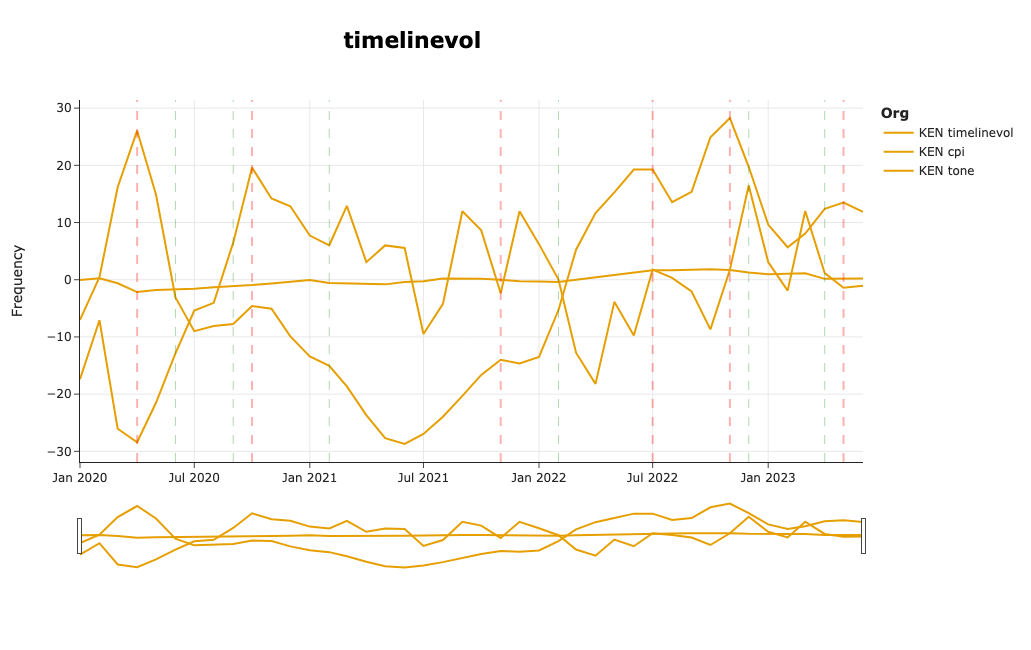

In [34]:
plot_timeseries(df.query(f"iso3=='KEN'"), smooth_x=1, show_infl=True, show_peaks=True)

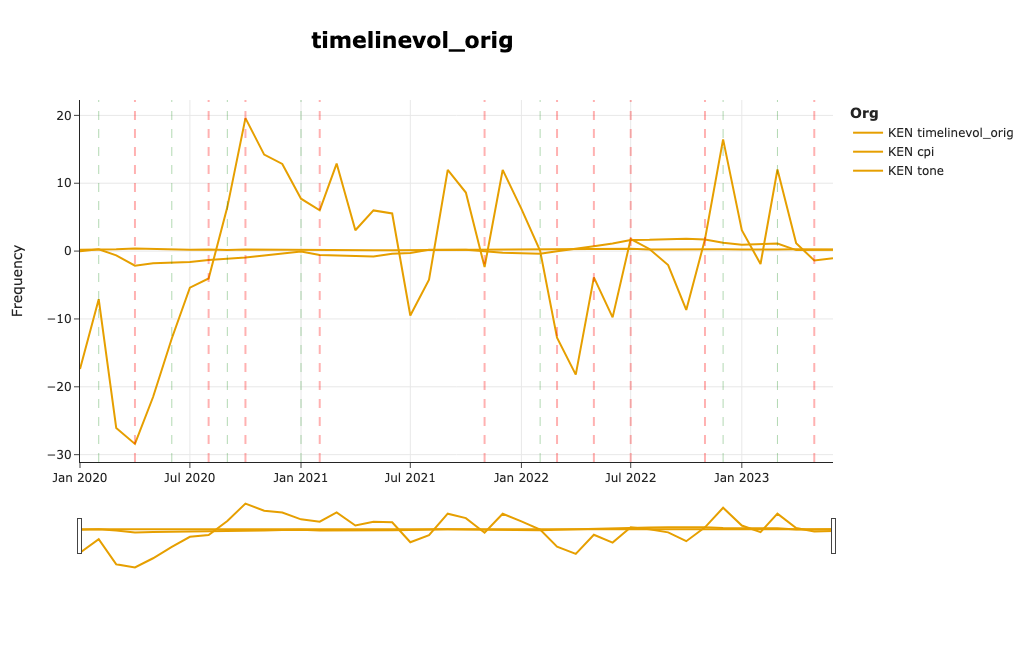

In [35]:
plot_timeseries(df.query(f"iso3=='KEN'"), colname='timelinevol_orig', smooth_x=None, )

In [36]:
# NOTE some dependencies may be missing
# https://github.com/rasbt/watermark/issues/74
%load_ext watermark
%watermark -u -i -m -v -iv --author ewheeler@unicef.org

Author: ewheeler@unicef.org

Last updated: 2023-11-04T22:03:50.629129+03:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

plotly    : 5.14.1
pandas    : 2.1.1
matplotlib: 3.6.3
seaborn   : 0.12.2
numpy     : 1.24.1

